## Objective:

**To apply KMeans clustering on Amazon Food Reviews**

KMeans is one of the simplest clustering algorithms available. It is an unsupervised learning method. It's also very fast as compared to other clustering methods.

In this notebook, I'll apply KMeans to amazon food reviews represented in various vector formats like -

* Bag of Words (BoW)
* Term frequency inverse document frequency (Tfidf)
* Avg. Word to Vector (W2V)
* Tfidf weighted W2V

For each vector type, I'll plot the elbow curve, i.e. the graph of K (#clusters) vs the loss value. The loss function is shown in the picture below.

I'll also create wordclouds from few sample reviews belonging to each cluster. I'll however not visualize the clusters through a graph, because as you will see ahead, the number of dimensions for each data point is HUGE! reducing them to 2-3 for visualization will result in significant loss of information, which will seriously limit the clustering capabilities of our model.

**The Loss Function of Kmeans**

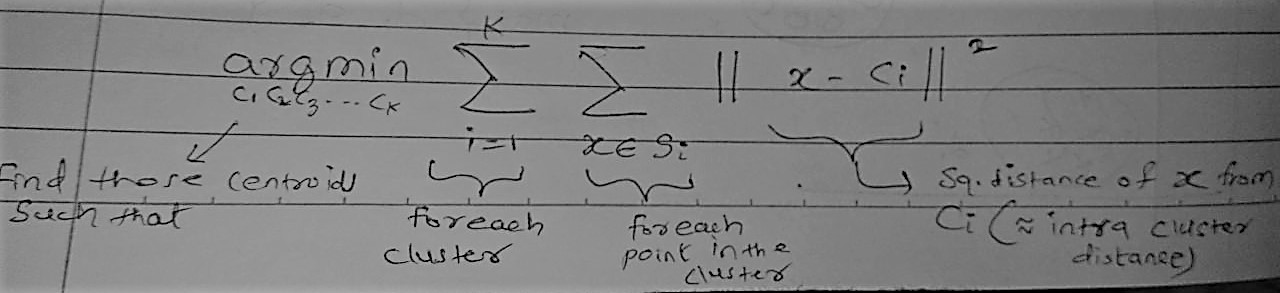

In [1]:
from IPython.display import Image
Image(r'C:\Users\ucanr\Dropbox\AAIC\assignments mandatory\10. Kmeans, HC, DBSCAN\loss function.jpg')

Let's begin by importing the necessary libraries. **wordcloud** is a library that we've not used prior to this notebook. We'll use it to represent reviews in clusters. And try to find if there's any discernable pattern in them.

In [2]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sbn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pickle
from scipy.sparse import vstack
from sklearn.model_selection import GridSearchCV
import sqlite3
from wordcloud import WordCloud

In [3]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

Let's define a couple of functions

* *plot_elbow_curve*
* *plot_wordcloud*: This will create wordclouds from 'n' samples reviews belonging to each cluster
* *cluster_distribution* : This function will print how many data points are present in each cluster i.e. how they are distributed.

In [4]:
def plot_elbow_curve(df, vector_type):
    """
        Plot the k(n_clusters) vs loss.
        The definition of the loss function can be found in the image above.
        This loss is provided by KMeans in sklearn through an attribute called "inertia_"
    """
    plt.figure(figsize=(15,6))
    plt.style.use('bmh')
    sbn.lineplot(data=df, x='k',y='loss')
    plt.margins(0.02)
    plt.xlabel('n_clusters(K)')
    plt.ylabel('Loss')
    plt.title('{} | Elbow Curve - K vs Loss'.format(vector_type))
    plt.yscale('linear')

In [5]:
def plot_wordcloud(prediction_array, df_reviews_clean, n):
    """
        Display K wordclouds for a certain value of K(#clusters) created using
        n sample reviews belonging to each cluster 
    """
    samples = []

    for cluster_no in np.unique(prediction_array):

        ix = np.where(prediction_array == cluster_no)
        
        samples.append(df_reviews_clean.iloc[ix]['cleaned_text'].head(n))
    
    
    plt.figure(figsize=(15,7))
    plt.style.use('bmh')
    
    for cluster_no in np.unique(prediction_array):
        
        big_review = ' '
        
        for review in list(samples[cluster_no]):
            
            big_review = big_review + review.decode('utf-8')
                    
        plt.subplot(2,5,cluster_no+1)
        wc = WordCloud(width=1500, height=1500).generate(big_review)
        _ = plt.imshow(wc, interpolation='bilinear')
        _ = plt.title('Cluster {}'.format(cluster_no))
        _ = plt.axis("off")

    
    _ = plt.show()
    _ = plt.tight_layout(pad=0)
    
    return samples

In [6]:
def cluster_distribution(predictions):
    
    for cluster_no in range(len(predictions)):
    
        cluster_bincounts = np.bincount(predictions[cluster_no])
        print('\ncluster k={} :\n{}'.format(len(cluster_bincounts), cluster_bincounts))

Load the cleaned text reviews stored on the disk. We'll need them to generate wordclouds. 

In [7]:
# con = sqlite3.connect(r'D:\data_science\datasets\amazon2\reviews_cleaned_final(1).sqlite')
con = sqlite3.connect('/home/ucanreachtvk/data/reviews_cleaned_final.sqlite')
df_reviews_clean = pd.read_sql('select cleaned_text from Reviews;', con)
con.close()

In [8]:
len(df_reviews_clean)

364171

## Bag of Words

Apply KMeans on BoW. Since this is an unsupervised learning method, we have no use for target variable 'y' and separate train/test sets. Therefore, we'll apply KMeans on a subset of the X dataset. The reason for not using all reviews is that as number of clusters increases, the algorithm takes a lot of time. As I'm trying clusters in range(10, 101, step=10), it will take hours to complete KMeans for just one type of vector.

So I'll limit the data to 50k points.

In [9]:
# f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_bow_full_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_train_transformed_bow_full_nparray.pkl', 'rb')
X_train_transformed_bow = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_bow is : {}'.format(type(X_train_transformed_bow)))
print('The shape of X_train_transformed_bow is : {}'.format(X_train_transformed_bow.shape))

The datatype of X_train_transformed_bow is : <class 'scipy.sparse.csr.csr_matrix'>
The shape of X_train_transformed_bow is : (291336, 64221)


In [10]:
X_train_transformed_bow = X_train_transformed_bow[:50000]

**Rescale data**

In [ ]:
scaler = StandardScaler(with_mean=False)
X_train_transformed_bow_std = scaler.fit_transform(X_train_transformed_bow)

**Run KMeans on BoW**

Let's fit a kmeans model for each of the 'k' values given in the list below. The **fit_predict** function creates clusters in the data and also predicts to which cluster each data point belongs. This prediction for each k is captured in the list predictions. Specify n_jobs to take advantage of multiple cpu cores.

In [13]:
%%notify
%%time

dict_k_vs_loss = {'k':[], 'loss':[]}

predictions = []

for k in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    kmeans = KMeans(n_clusters=k, n_jobs=4)
    predictions.append(kmeans.fit_predict(X_train_transformed_bow_std))
    dict_k_vs_loss['k'].append(k)
    dict_k_vs_loss['loss'].append(kmeans.inertia_)
    print('done k:= {} '.format(k))

done k:= 10 
done k:= 20 
done k:= 30 
done k:= 40 
done k:= 50 
done k:= 60 
done k:= 70 
done k:= 80 
done k:= 90 
done k:= 100 
CPU times: user 32min 48s, sys: 59.6 s, total: 33min 48s
Wall time: 26min 33s


<IPython.core.display.Javascript object>

**Cluster Distribution | BoW**

Following is a distribution of reviwes. Unfortunately, BoW did not yield clearly distributed clusters. Most of the data points are concentrated in one of the clusters. 

In [14]:
cluster_distribution(predictions)


cluster k=10 :
[   40 49948     1     4     1     1     2     1     1     1]

cluster k=20 :
[    1     6     1     8     1     1     1     1     1   186     1 49784
     1     1     1     1     1     1     1     1]

cluster k=30 :
[    3     1     4     5 49952     1     1     1     1     1     1     1
     4     1     1     1     1     1     1     1     1     3     1     1
     1     4     1     3     1     1]

cluster k=40 :
[   16     1     1     1     3     1     1 49938     1     1     1     1
     1     1     1     1     1     1     1     4     1     3     1     1
     1     1     1     1     2     1     1     1     1     1     1     1
     1     1     1     1]

cluster k=50 :
[    1     1     1     1     1     1     1     1     1     1    66     1
     1     2     1     1     1   319     1     1     1     1     1     1
     1     1     1     1     1     1     1 49561     1     6     1     1
     1     1     1     1     1     1     1     1     1     2     1     1
     1     1]


Convert the dictionary into a Pandas dataframe to create a lineplot from it using Seaborn.

In [15]:
df_k_vs_loss= pd.DataFrame(dict_k_vs_loss)

**Elbow curve | BoW**

Plot elbow curve to see the loss for each value of K

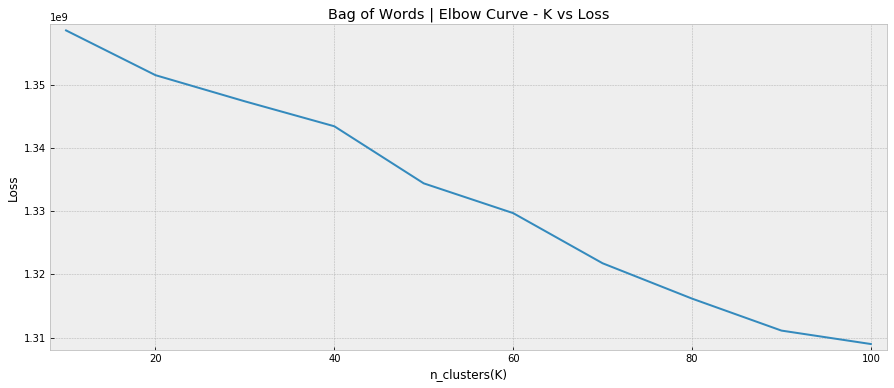

In [16]:
plot_elbow_curve(df_k_vs_loss, vector_type='Bag of Words')

The elbow curve of KMeans does not really have an 'elbow'. i.e. the curve will keep its downward trend as K increases. Let's choose k=10 for further analysis.

**WordCloud | BoW**

For K = 10, our reviews have been divided into 10 clusters. The predicted cluster number for each review has been stored in the list 'prediction' I defined above. Predictions for the 10th cluster are at prediction[0] since 10 is stored at index 0
in the list through which k is iterating to fit KMeans.

Let's generate wordclouds using n=1000 sample reviews from each cluster. Note that there can be clusters which have < n reviews in it.

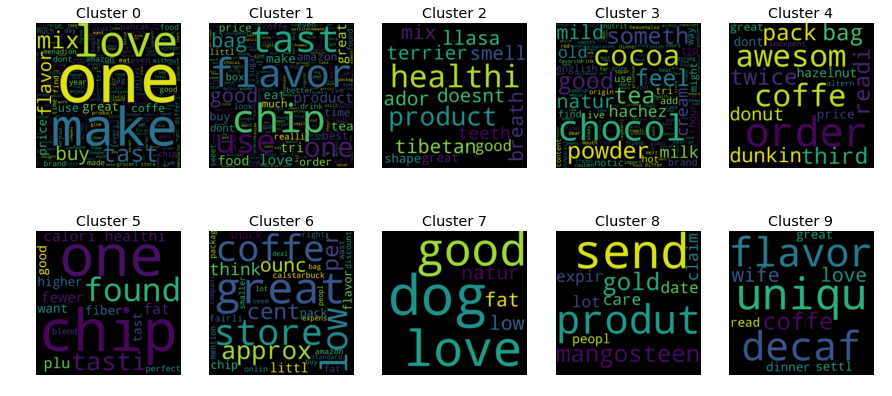

<Figure size 432x288 with 0 Axes>

In [18]:
_ = plot_wordcloud(predictions[0], df_reviews_clean, n=1000)

Trying to derive some pattern in the above wordclouds is not advised. Because, as we saw above in the cluster distributions, most of the reviews belong to cluster #1. The other clusters don't have sufficient quantity of reviews in them for us to observe a legitimate pattern.

But we can say something about cluster #1. 'Flavor', 'chip' and 'tasty' are the words found most frequently in these reviews.

## Tfidf

Let's perform the same analysis, this time on Tfidf. Start by loading the data stored on disk.

In [19]:
# f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_tfidf_full_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_train_transformed_tfidf_full_nparray.pkl', 'rb')
X_train_transformed_tfidf = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_tfidf is : {}'.format(type(X_train_transformed_tfidf)))
print('The shape of X_train_transformed_tfidf is : {}'.format(X_train_transformed_tfidf.shape))

The datatype of X_train_transformed_tfidf is : <class 'scipy.sparse.csr.csr_matrix'>
The shape of X_train_transformed_tfidf is : (291336, 64221)


In [21]:
X_train_transformed_tfidf = X_train_transformed_tfidf[:50000]

**Rescale data**

In [22]:
scaler = StandardScaler(with_mean=False)
X_train_transformed_tfidf_std = scaler.fit_transform(X_train_transformed_tfidf)

**Run KMeans on Tfidf**

In [23]:
%%notify
%%time

dict_k_vs_loss = {'k':[], 'loss':[]}

predictions = []

for k in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    kmeans = KMeans(n_clusters=k, n_jobs = 4)
    predictions.append(kmeans.fit_predict(X_train_transformed_tfidf_std))
    dict_k_vs_loss['k'].append(k)
    dict_k_vs_loss['loss'].append(kmeans.inertia_)
    print('done k:= {} '.format(k))

done k:= 10 
done k:= 20 
done k:= 30 
done k:= 40 
done k:= 50 
done k:= 60 
done k:= 70 
done k:= 80 
done k:= 90 
done k:= 100 
CPU times: user 1h 2min 17s, sys: 1min 49s, total: 1h 4min 7s
Wall time: 53min 4s


<IPython.core.display.Javascript object>

**Cluster Distributions | Tfidf**

Similar to BoW, KMeans on Tfidf doesn't generate well seperated clusters. Most of the reviews are concentrated in a single cluster. 

In [25]:
cluster_distribution(predictions)


cluster k=10 :
[    7 49985     1     1     1     1     1     1     1     1]

cluster k=20 :
[   15    14     3    59     1     1     1     1 49892     1     1     3
     1     1     1     1     1     1     1     1]

cluster k=30 :
[    1     1     4    90     1     1     1     1     1     8     1     1
   333     1    17     1     1     1     1     1     1     1     1     1
     1     1     1     1 41915  7610]

cluster k=40 :
[    3     6     1    20     1     1     1   349     1     1     1     1
  3071     1 46513     1     1     1     1     1     1     1     1     1
     1     1     3     1     3     1     1     1     1     1     1     1
     1     1     1     1]

cluster k=50 :
[   53     1     1     1     1     1     1     1     1     1     3    29
     1     1     1     1     1     1     1     1     1    50     1     1
     1     1     1     1     7     1     1     1     1     2     1     5
 49805     1     1     1     1     1     1     1     1     1     1     1
     1     5]


In [26]:
df_k_vs_loss= pd.DataFrame(dict_k_vs_loss)

**Elbow curve | Tfidf** 

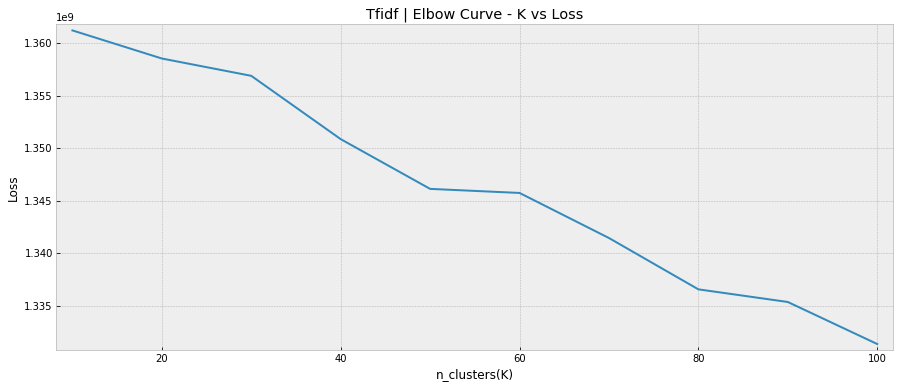

In [27]:
plot_elbow_curve(df_k_vs_loss, vector_type='Tfidf')

**WordCloud | Tfidf**

Let's generate wordclouds for k=10. But here again, since most of the reviews belong to cluster #1, we'll observe only that.

The words Flavor, taste, chip are used most frequently.

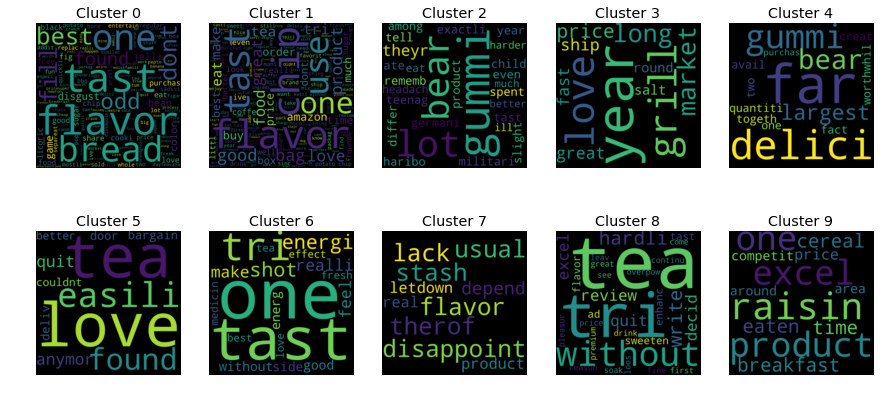

<Figure size 432x288 with 0 Axes>

In [28]:
_ = plot_wordcloud(predictions[0], df_reviews_clean, n=1000)

## Avg W2V

Apply KMeans on W2V data. Start by loading the datasets.

In [43]:
# f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_avgW2V_full80_20_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_train_transformed_avgW2V_full80_20_nparray.pkl', 'rb')
X_train_transformed_avgW2V = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_avgW2V is : {}'.format(type(X_train_transformed_avgW2V)))
print('The shape of X_train_transformed_avgW2V is : {}'.format(X_train_transformed_avgW2V.shape))

The datatype of X_train_transformed_avgW2V is : <class 'numpy.ndarray'>
The shape of X_train_transformed_avgW2V is : (291336, 50)


In [44]:
X_train_transformed_avgW2V = X_train_transformed_avgW2V[:50000]

**Rescale data**

In [45]:
scaler = StandardScaler(with_mean=True)
X_train_transformed_avgW2V_std = scaler.fit_transform(X_train_transformed_avgW2V)

**Run KMeans on Avg. W2V**

In [46]:
%%notify
%%time

dict_k_vs_loss = {'k':[], 'loss':[]}

predictions = []

for k in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    kmeans = KMeans(n_clusters=k, n_jobs=8)
    predictions.append(kmeans.fit_predict(X_train_transformed_avgW2V_std))
    dict_k_vs_loss['k'].append(k)
    dict_k_vs_loss['loss'].append(kmeans.inertia_)
    print('done k:= {}'.format(k))

done k:= 10
done k:= 20
done k:= 30
done k:= 40
done k:= 50
done k:= 60
done k:= 70
done k:= 80
done k:= 90
done k:= 100
CPU times: user 17min 42s, sys: 1min 22s, total: 19min 4s
Wall time: 9min 35s


<IPython.core.display.Javascript object>

**Cluster Distribution | Avg. W2V**

Kmeans does a better job of seggerigating reviews into distinct clusters as compared to BoW and Tfidf. Almost all the clusters have sizeable number of reviews in them.

In [48]:
cluster_distribution(predictions)


cluster k=10 :
[  117  7807 26830  2265  6031  1919   869   373   211  3578]

cluster k=20 :
[  990  4833   787 18971    71   546  6422   151   612  1044   118    17
  1577  5746   519     8  2634   234    33  4687]

cluster k=30 :
[ 1708  3852   663   106  3062   460  4230    11  2438   808   126     5
  1723   702   845   116   385  5769   826   101    75   160    31   497
   398    69  4352    43  1367 15072]

cluster k=40 :
[ 1255  2236  1042 12851   124   591   394   990  3363   115   343  1139
     9    54    42     6    96  1513    79   132    33  5489   648   554
  3644  3640   339    96  1230   492     7  4383    88     4    27    43
   298  2169    21   421]

cluster k=50 :
[ 165 5337   40   72 1096    4 1107 2227 1166  340   56  504 1507   60
  423 3501 9535 3485  239    6    9   42  971 1775  690   90   42  229
   81   20  283 1091   88   92  247  340    1   41 3606   16 3413 2028
   17  809  481  146 1939  348   26  169]

cluster k=60 :
[1074  240 3576  202  986   81 1227

In [49]:
df_k_vs_loss= pd.DataFrame(dict_k_vs_loss)

**Elbow curve | Avg. W2V**

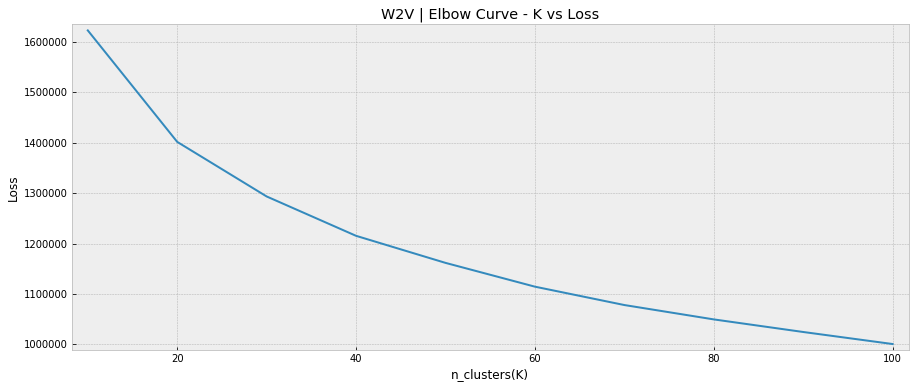

In [50]:
plot_elbow_curve(df_k_vs_loss, vector_type='W2V')

**Sample Reviews**

Generate wordclouds for k=10.

The words flavor & taste are common to all of them. However, we can see some subtle differences. 

* 'tea' is found a lot in cluster #0

* 'chip' is found a lot in cluster #2

* 'coffee' is found mostly in cluster #3

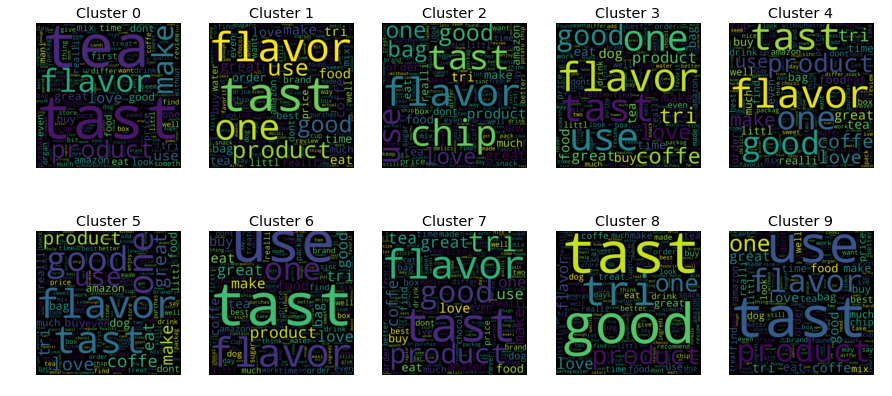

<Figure size 432x288 with 0 Axes>

In [53]:
_ = plot_wordcloud(predictions[0], df_reviews_clean, n=1000)

## Tfidf wt. W2V

Apply Kmeans on data in Tfidf wt. W2V.

In [54]:
# f = open(r'D:\data_science\datasets\amazon2\X_train_transformed_TfidfWeightedW2V_full80_20_nparray.pkl', 'rb')
f = open('/home/ucanreachtvk/data/X_train_transformed_TfidfWeightedW2V_full80_20_nparray.pkl', 'rb')
X_train_transformed_TfidfW2V = pickle.load(f)
f.close()
print('The datatype of X_train_transformed_TfidfW2V is : {}'.format(type(X_train_transformed_TfidfW2V)))
print('The shape of X_train_transformed_TfidfW2V is : {}'.format(X_train_transformed_TfidfW2V.shape))

The datatype of X_train_transformed_TfidfW2V is : <class 'numpy.ndarray'>
The shape of X_train_transformed_TfidfW2V is : (291336, 50)


In [55]:
X_train_transformed_TfidfW2V = X_train_transformed_TfidfW2V[:50000]

**Rescale Data**

In [56]:
scaler = StandardScaler(with_mean=True)
X_train_transformed_TfidfW2V_std = scaler.fit_transform(X_train_transformed_TfidfW2V)

**Run KMeans on Tfidf wt. W2V**

In [57]:
%%notify
%%time

dict_k_vs_loss = {'k':[], 'loss':[]}

predictions = []

for k in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    kmeans = KMeans(n_clusters=k, n_jobs=4)
    predictions.append(kmeans.fit_predict(X_train_transformed_TfidfW2V_std))
    dict_k_vs_loss['k'].append(k)
    dict_k_vs_loss['loss'].append(kmeans.inertia_)
    print('done k:= {}'.format(k))

done k:= 10
done k:= 20
done k:= 30
done k:= 40
done k:= 50
done k:= 60
done k:= 70
done k:= 80
done k:= 90
done k:= 100
CPU times: user 16min 10s, sys: 39 s, total: 16min 49s
Wall time: 8min 30s


<IPython.core.display.Javascript object>

**Cluster Distributions | Tfidf wt. W2V**

Unlike BoW and Tfidf, the reviews are more evenly distributed across clusters

In [58]:
cluster_distribution(predictions)


cluster k=10 :
[ 6202  4453  3351 10235  3215  4404  2861  3601  6743  4935]

cluster k=20 :
[2484 3150 1165 1900 2344 4765 1536 3432 1591 2159 4832 2028 2526 2505
 2657 1275 2649 1386 2505 3111]

cluster k=30 :
[2387 3416 3125 1233 2922 2258 2313 1253 1052  938 1379 1019 1259 1970
  946  833 1147 1845 1214 1873  997 2063 2548 1918 1137  776 1207 1982
 2061  929]

cluster k=40 :
[1152 1095 1603 2517  852  800 2288 2173 1175 1774 1019 1765  898 1555
  548  825 1090  707  124 1635 1509 1310 1673  952  942  754 1485 2905
  621  907  618  562  468  860  840 2554 1244 1604  930 1667]

cluster k=50 :
[1248 1638  956 1334  330 1270  770  818  769 1246 2024 1435  605 2149
 1022  507  438 1892  359  126 1344 1090  961  696  771  608  554  677
  462  817 1311  782 1342 1632  982  775  835 1210 1468  780 1063  717
 1108 2027  540  729  763  711  710 1599]

cluster k=60 :
[ 210  789 1282 1832 1324  462  122 1435  437  854 1181  513  773 1961
  742 1440  345 1305  986  318 1596  393  969  509  863

In [59]:
df_k_vs_loss= pd.DataFrame(dict_k_vs_loss)

**Elbow curve | Tfidf wt. W2V**

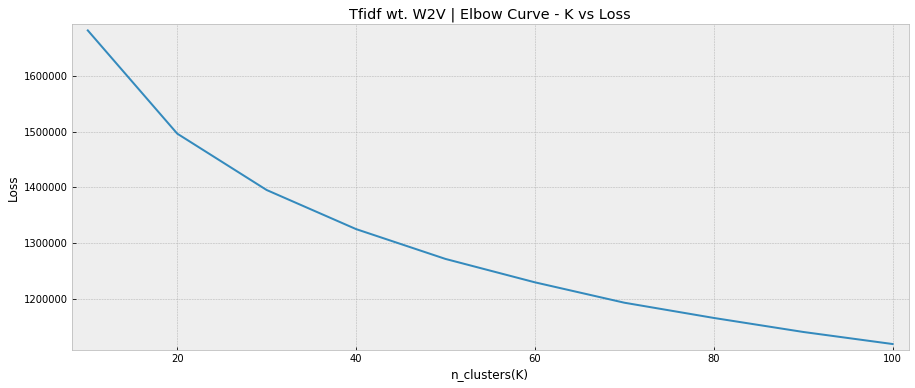

In [60]:
plot_elbow_curve(df_k_vs_loss, vector_type='Tfidf wt. W2V')

**WordCloud | Tfidf wt. W2V**

For k=10.

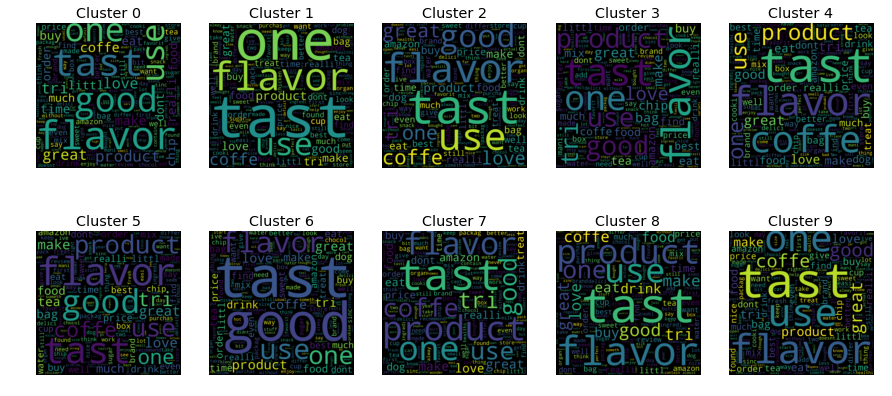

<Figure size 432x288 with 0 Axes>

In [62]:
_ = plot_wordcloud(predictions[0], df_reviews_clean, n=1000)

## Conclusion:

* Applied KMeans clustering on Amazon Food Reviews for various vector formats
* Analysed how the elbow curve behaves for Kmeans
* Plotted wordclouds of reviews belonging to each cluster